## Bayesian Optimisation Verification

In [1]:
# import relevant packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
# stop showing warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# Setup data for training and evaluation
X_ = np.linspace(0,5000, 5000)
# import timestamp from data sheet (time:0~5000s) 
address = 'data/degradation.xlsx'
df_time = X_
# import data sheet at 85 C (time:0~5000s) 
df = pd.read_excel(address,sheet_name = 'normal data',usecols = [3],names = None,nrows = 5000)
df_85 = df.values.tolist() 
df = pd.read_excel(address,sheet_name = 'smooth data',usecols = [3],names = None,nrows = 5000)
df_85s = df.values.tolist()
# Format date into numpy array format
y_normal = np.array(df_85).T 
y_normal = y_normal.reshape((5000))
x_normal = X_
x_7_5000 = np.array([0,99,999,1999,2999,3999,4999])

[   0    4    8 ... 4788 4792 4796]


In [44]:
# Plot function to show confidence bounds 
def plot(X_,y_normal,X,y_mean, sigma,gp):
    plt.figure()
    plt.plot(X_, y_mean, c='blue', lw=1, zorder=4, label='Prediction')
    plt.scatter(X[:, 0], Y, c='r', s=5, zorder=3,label='Trained data')
    plt.fill_between(X_, y_mean - 1.9600 * sigma,y_mean + 1.9600 * sigma,
                        alpha=0.5,color='grey',zorder=1, label='95% confidence interval')
    plt.scatter(X_,y_normal,c='lightblue',s=1,zorder=2, label='Experiment data')
    plt.tick_params(axis='y', colors = 'white')
    plt.tick_params(axis='x', colors = 'white')
    plt.ylabel('Lifetime',color = 'white')
    plt.xlabel('Time',color = 'white')
    plt.title("Initial: %s\nOptimum: %s\nLog marginal likelihood: %s" % 
                (kernel, gp.kernel_,gp.log_marginal_likelihood(gp.kernel_.theta)),
                color ='white')
    plt.legend()
    plt.tight_layout()
    plt.show()

Number of data points used: 5


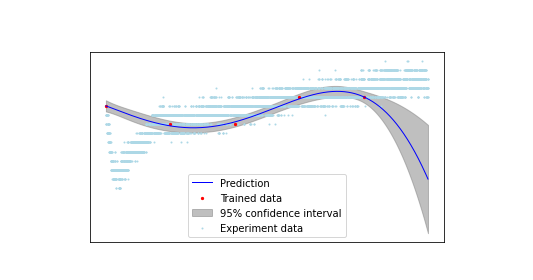

Number of data points used: 10


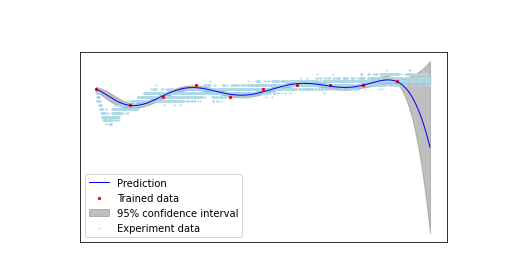

Number of data points used: 15


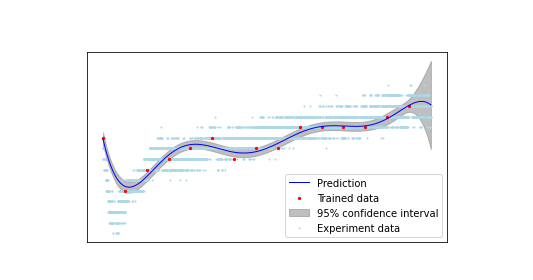

Number of data points used: 20


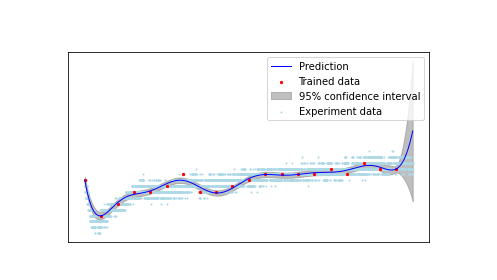

Number of data points used: 22


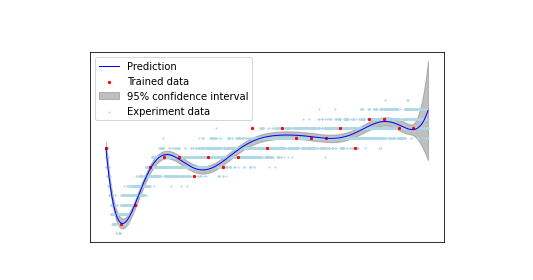

Number of data points used: 24


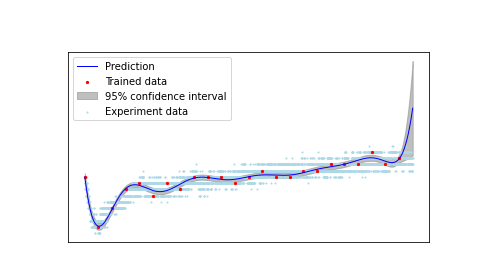

Number of data points used: 26


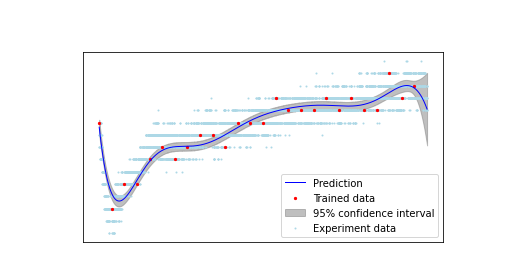

Number of data points used: 28


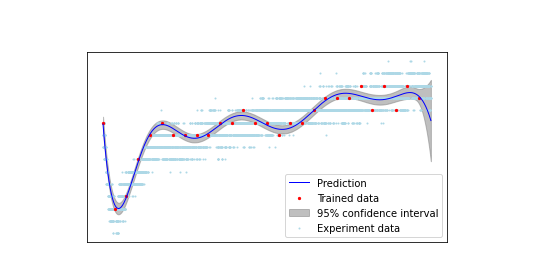

Number of data points used: 30


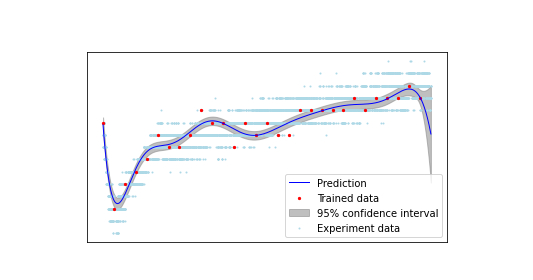

Number of data points used: 33


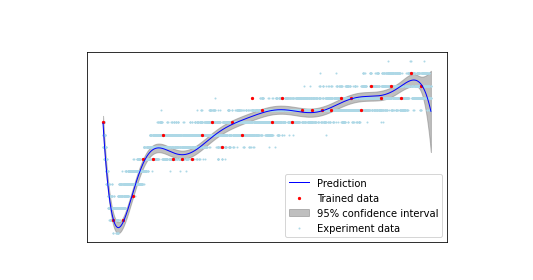

Number of data points used: 37


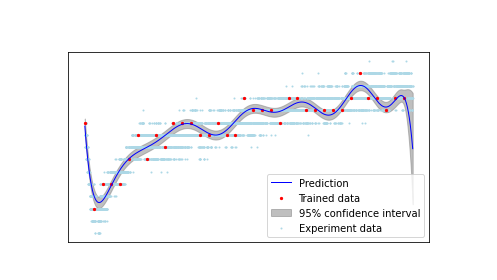

Number of data points used: 40


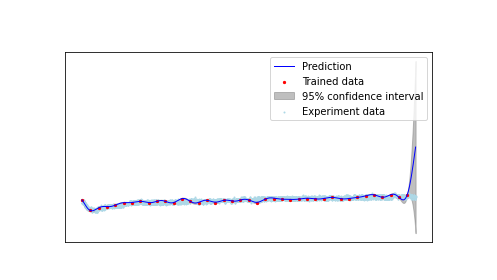

Number of data points used: 45


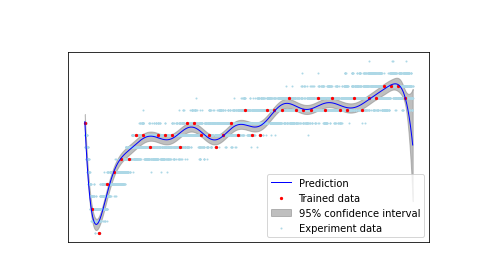

Number of data points used: 50


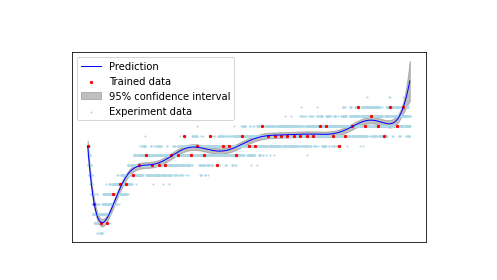

Number of data points used: 60


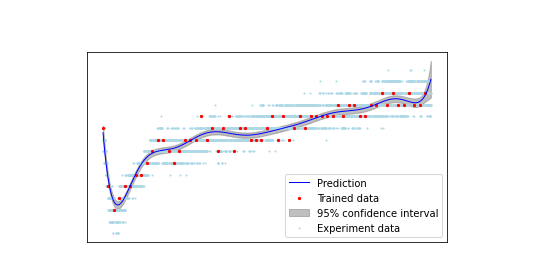

Number of data points used: 80


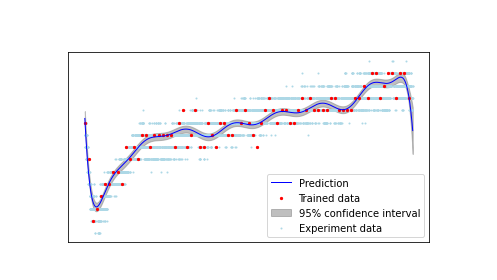

Number of data points used: 100


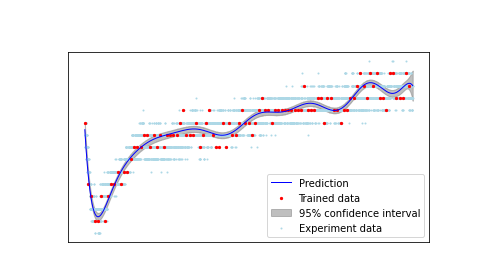

Number of data points used: 200


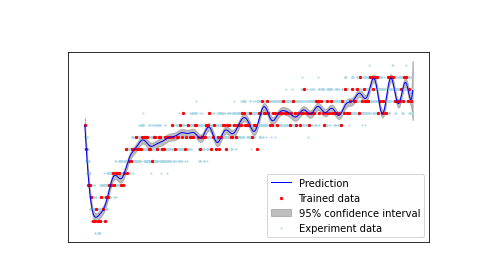

Number of data points used: 250


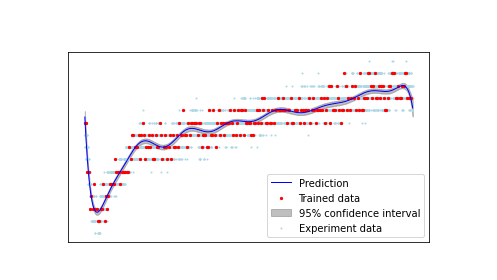

Number of data points used: 300


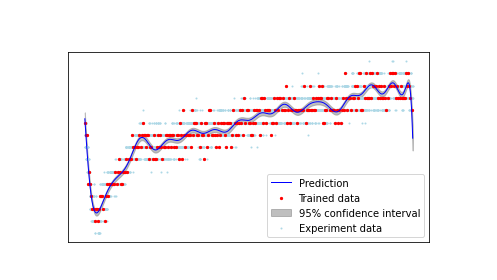

Number of data points used: 400


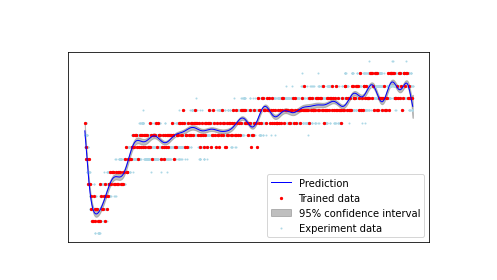

Number of data points used: 500


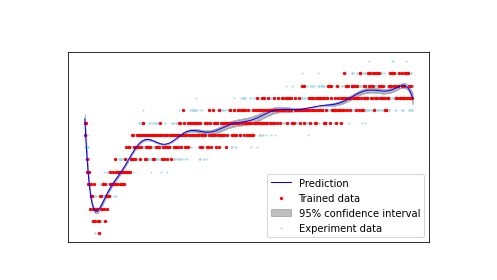

Number of data points used: 600


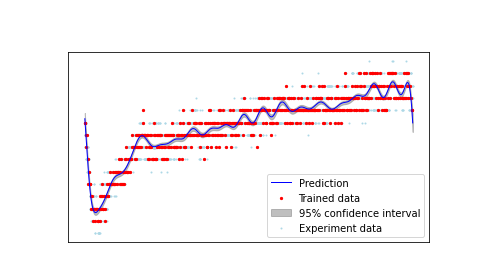

Number of data points used: 700


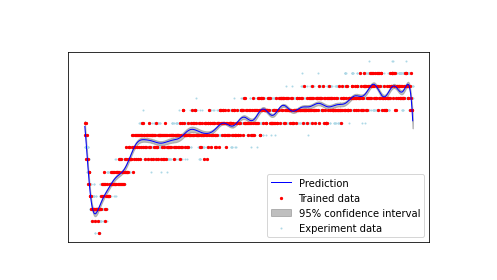

Number of data points used: 800


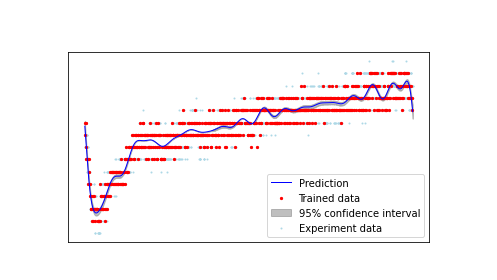

Number of data points used: 1000


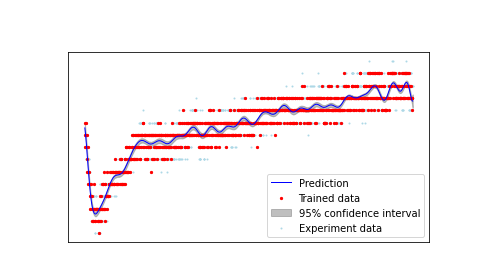

Number of data points used: 1200


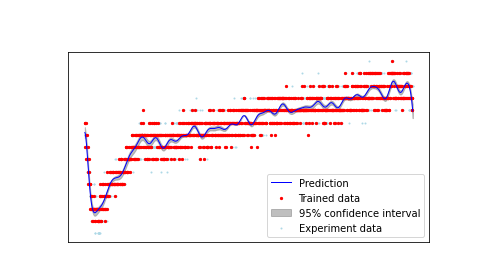

Number of data points used: 1400


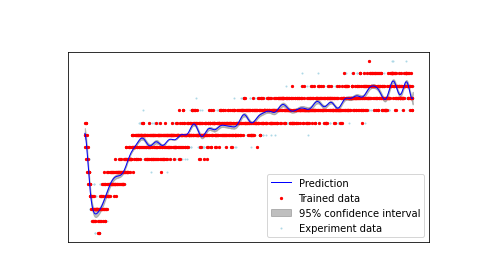

Number of data points used: 1700


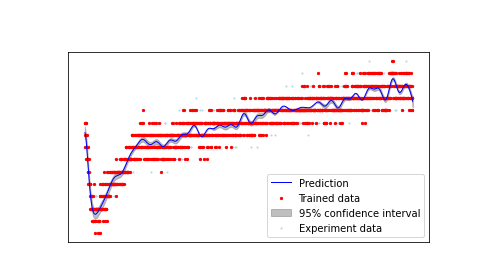

Number of data points used: 2000


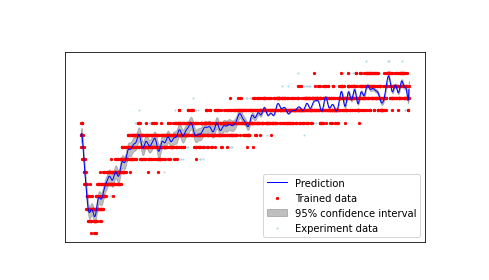

Number of data points used: 2500


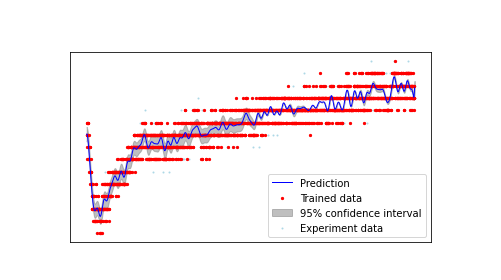


Mean squared error


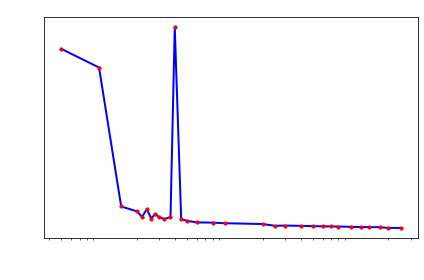

Log marginal likelihood


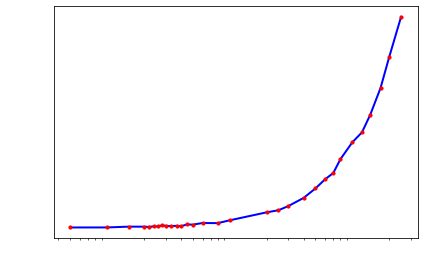

In [58]:
# Ploting how noise level would affect gp's performance

# Prepare a list of noise levels to test
# list_NOISE_LEVEL = np.array([])
# for i in range(-20,2): 
#     list_NOISE_LEVEL = np.append(list_NOISE_LEVEL,10**i)
# Set up performance parameters set
list_mse = np.array([])
list_lml = np.array([])

# NUM_OF_DATA_POINTS = 20
NOISE_LEVEL = 10e-20
length_scale_bounds_MAX = 10e4
length_scale_bounds_MIN = 10e-10
# 
list_DATA_POINTS = (5,10,15,20,22,24,26,28,30,33,37,40,45,50,60,80,100,200,250,300,400,500,600,700,800,1000,1200,1400,1700,2000,2500)
for NUM_OF_DATA_POINTS in list_DATA_POINTS: 
    # Have data points evenly spread
    X = np.arange(0,5000,5000/NUM_OF_DATA_POINTS).astype(int)
    # Randomly chosed data points
    # X = np.random.randint(5000, size=NUM_OF_DATA_POINTS)
    X = X.reshape(X.size,1)
    Y = y_normal[X]
    print('Number of data points used:', X.size)

    # Kernel setting
    kernel = 1.0 * RBF(length_scale=300) + WhiteKernel(noise_level=NOISE_LEVEL, noise_level_bounds=(1e-20, 10e-4))
    gp = GaussianProcessRegressor(kernel=kernel,alpha=10e-8).fit(X, Y)
    y_mean, sigma = gp.predict(X_[:, np.newaxis],  return_std=True)
    y_mean = y_mean.reshape(5000)
    sigma = sigma.reshape(5000)
    plot(X_,y_normal,X,y_mean, sigma,gp)

    # print('Noise level =',NOISE_LEVEL)

    # print ('Average absolute error:',
    # np.format_float_scientific(np.mean(np.absolute(y_normal-y_mean)),precision=5))
    # print ('Average percentage error:', np.format_float_positional(np.mean(np.absolute((y_normal-y_mean)/y_normal*100)),precision=4),'%')
    mse = mean_squared_error(y_normal,y_mean)
    # print ('Mean squared error:', mse)
    lml = gp.log_marginal_likelihood(gp.kernel_.theta)
    # print ('Log marginal likelihood:', log_marginal_likelihood)

    list_mse = np.append(list_mse,mse)
    list_lml = np.append(list_lml,lml)

# plot relevant graphs
print('\nMean squared error')
plot_performance(list_DATA_POINTS,list_mse)
print('Log marginal likelihood')
plot_performance(list_DATA_POINTS,list_lml)